# 3 Pre-Processing & Training

In our last step, we did some joining of our data based on latitude and longitude and explored our features. In this next step we will prepare for modeling by tuning our features, and maybe even adding a feature or two. We will have some challenges with finding the right mix and tuning of features when our initial correlation review didn't show much to work with. Maybe more challenging will be how to deal with our fairly imbalanced data.

## 3.0 Imports

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from imblearn.over_sampling import SMOTENC #using SMOTENC because it accepts a mix of numeric and categorical values

## 3.1 Load Data

In [3]:
trees_df = pd.read_csv('../data/data_outputs/seattle_trees_explored.csv')

trees_df.head(3)

,planted_date,most_recent_observation,common_name,long_trees,lat_trees,diameter_breast_height_CM,condition,native,age_at_obs,condition_index,nearest_station,station_id,station_name,lat_prcp,long_prcp,adj_reports,norm_prcp_mm_total,norm_snow_mm_total,distance_between,tree_id
0,1991-07-22,2019-04-27,(european) white birch,-122.282080,47.635207,40.64,excellent,introduced,27.765115,5.0,WA-KG-266,WA-KG-266,Seattle 2.9 ENE,47.630883,-122.290286,237,1071.925479,0.0,0.947927,1
1,1991-07-30,2019-04-27,Kwanzan flowering cherry,-122.318952,47.649141,5.08,fair,no_info,27.743212,3.0,WA-KG-266,WA-KG-266,Seattle 2.9 ENE,47.630883,-122.290286,237,1071.925479,0.0,3.367105,2
2,1991-07-25,2019-04-27,Japanese snowbell tree,-122.299891,47.637863,2.54,excellent,introduced,27.756901,5.0,WA-KG-266,WA-KG-266,Seattle 2.9 ENE,47.630883,-122.290286,237,1071.925479,0.0,1.145690,3


## 3.2 Prep DF for Train-Test split

We'll take another look at the columns, as we can likely drop the additional reference info from our climate 'prcp' data source. And then we'll split our dependent and independent variables.

### 3.2.0 Drop Unecessary Columns

We'll drop the reference cols from climate data like I mentioned above, but also the 'condition' column because it is duplicative of our target feature. Our tree_id because it has no more use. And our date cols, because we have the calculated age feature that will be our variable related to dates/ages.

In [4]:
#View our columns
trees_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158004 entries, 0 to 158003
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   planted_date               155133 non-null  object 
 1   most_recent_observation    157999 non-null  object 
 2   common_name                157332 non-null  object 
 3   long_trees                 158004 non-null  float64
 4   lat_trees                  158004 non-null  float64
 5   diameter_breast_height_CM  158004 non-null  float64
 6   condition                  158004 non-null  object 
 7   native                     158004 non-null  object 
 8   age_at_obs                 155128 non-null  float64
 9   condition_index            158004 non-null  float64
 10  nearest_station            158004 non-null  object 
 11  station_id                 158004 non-null  object 
 12  station_name               158004 non-null  object 
 13  lat_prcp                   15

In [5]:
#drop our columns that are reference from climate dataset and the original condition column (which we used to create our target index feature)
trees_df = trees_df.drop(columns=['nearest_station', 'station_id',
       'station_name', 'lat_prcp', 'long_prcp', 'condition', 'planted_date','most_recent_observation','tree_id','long_trees','lat_trees'])

In [6]:
trees_df.columns

Index(['common_name', 'diameter_breast_height_CM', 'native', 'age_at_obs',
       'condition_index', 'adj_reports', 'norm_prcp_mm_total',
       'norm_snow_mm_total', 'distance_between'],
      dtype='object')

### 3.2.1 Sample Dataset to Make Size More Manageable
One model may not be too crazy, but running a gridsearch CV on hundreds of thousands of rows may be a bit much for me. I'll start with a sample of 10,000.

In [7]:
trees_sample = trees_df.sample(n=10000, replace=False, random_state=42)

### 3.2.2 Split Dependent and Independent Variables

In [8]:
# split data into X and y
X = trees_sample.drop(columns=['condition_index'])
y = trees_sample['condition_index']

## 3.3 Train-Test Split
We'll use an 80:20 split here

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8000, 8) (8000,) (2000, 8) (2000,)


## 3.4 Impute Missing Values

We will use the median for our age at observation and mode for common name.

### 3.4.0 Calculate Modes and Means

In [10]:
X_median_age = X_train['age_at_obs'].median()
X_mode_name = X_train['common_name'].mode()

### 3.4.1 Impute Values

In [11]:
#Impute planted_date
X_train['age_at_obs'] = X_train['age_at_obs'].fillna(X_median_age)
X_train['common_name'] = X_train['common_name'].fillna(X_mode_name[0]) #using 0 index to grab the name of the mode

In [12]:
#validate no missing values
X_train.isna().sum()

common_name                  0
diameter_breast_height_CM    0
native                       0
age_at_obs                   0
adj_reports                  0
norm_prcp_mm_total           0
norm_snow_mm_total           0
distance_between             0
dtype: int64

## 3.5 Simple Feature Engineering

Before running a first test model, I'll do some basic feature engineering. After testing on a single model we'll move into doing further tuning.

### 3.5.1 Feature Scaling

I'll start by reviewing distributions of our numerical variables to see if we need to do any column specifc scaling or if we can apply some standard methodology.

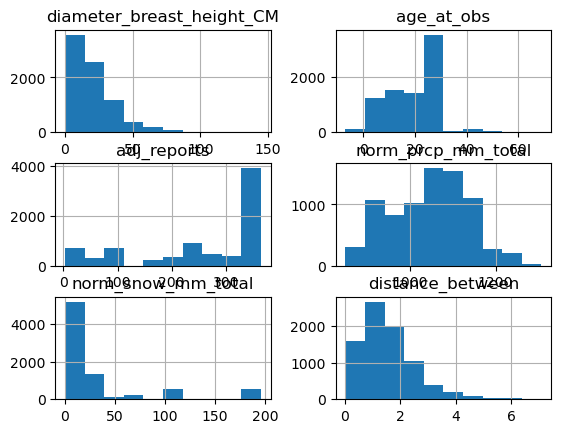

In [13]:
X_train.hist()
plt.show()

diameter, snowfall, and distance between are pretty tailed, so I may try some log transformation on them. age and rainfall I will start with standardscaler.

In [14]:
#initiate standard scaler
ss_scaler = StandardScaler()

#fit to age and prcp data
ss_scaler.fit(X_train[['age_at_obs','norm_prcp_mm_total']])

StandardScaler()

In [15]:
#initiate log transformer
pow_trans = PowerTransformer()

#fit to snow,diameter, and distance betweena
pow_trans.fit(X_train[['diameter_breast_height_CM', 'norm_snow_mm_total','distance_between','adj_reports']])

PowerTransformer()

### 3.5.2 Categorical Encoding

We'll need to encode our categorical features. And for our tree names, we'll likely need to group together some of the less frequent options so we don't overwhelm our model with a crazy number of columns.

In [16]:
cat_columns = trees_df.select_dtypes(include='object').columns

cat_columns

Index(['common_name', 'native'], dtype='object')

In [17]:
#view value_counts of common_name field
trees_df['common_name'].value_counts()

Red maple                     5218
Apple/crabapple               4653
Norway maple                  4510
Purpleleaf plum variety       4313
(smooth) japanese maple       4193
                              ... 
Silver leaved mountain gum       2
Doublefile viburnum              2
Shade king red maple             2
Spindle tree                     2
Hokusai flowering cherry         2
Name: common_name, Length: 670, dtype: int64

In [18]:
#how many of the 670 categories have less than 10 records?

vc = pd.DataFrame(trees_df['common_name'].value_counts())

vc.reset_index(inplace=True)

vc[vc['common_name'] < 10].value_counts()

index                         common_name
(pink) idaho locust           9              1
Serbian spruce                3              1
Pagoda dogwood                7              1
Parney cotoneaster            3              1
Pink spires crabapple         5              1
                                            ..
Eugene`s (carolina) poplar    6              1
European white elm            8              1
Fastigiata western red cedar  5              1
Firefall freeman maple        6              1
Wych elm                      3              1
Length: 163, dtype: int64

In [19]:
#view value_counts of common_name field
trees_df['native'].value_counts()

introduced             116127
no_info                 32616
naturally_occurring      9261
Name: native, dtype: int64

#### 3.5.2.0 Convert common_name Field to Group Names with < 100 Occurences

This will limit the number of columns we have. We won't do thes ame for the native field. We'll do it by defining a function that can be utilized later as well.

In [20]:
def group_categories(df, col, n_limit):
    """ Store categories in df[col] with counts less than the specified n and overwrite the corresponding values in the df with 'Other' """
    groups = df[col]
    group_counts = groups.value_counts()
    mask = groups.isin(group_counts[group_counts<n_limit].index)
    df.loc[mask, col] = 'Other'

In [21]:
#use our group categories feature on our X_train set
group_categories(X_train, 'common_name', 10)

X_train['common_name'].value_counts()

Other                       1032
Red maple                    330
Purpleleaf plum variety      237
Norway maple                 216
Apple/crabapple              215
                            ... 
Pacific dogwood               10
Largeleaf crabapple           10
Tuscorara crapemyrtle         10
Red cascade mountain ash      10
Raywood narrowleaf ash        10
Name: common_name, Length: 155, dtype: int64

#### 3.5.2.1 Run OHE On Our Object Variables

In [22]:
#create a onehotencoder instance
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')

#fit on our test set
ohe.fit(X_train[['common_name','native']])

OneHotEncoder(drop='first', handle_unknown='ignore')

## 3.6 First Model

Now that we've done some basic tuning, let's do some transforming with the feature engineering tools we fit and run a logistic regression model to see what we get.

In [23]:
X_train.head()

,common_name,diameter_breast_height_CM,native,age_at_obs,adj_reports,norm_prcp_mm_total,norm_snow_mm_total,distance_between
85168,Common serviceberry,7.62,introduced,3.652368,217,849.190323,0.0,1.243978
85613,Red maple,7.62,no_info,11.641581,217,849.190323,0.0,0.317906
11471,Other,12.70,introduced,19.154397,347,1138.700000,35.0,1.330051
57576,American hornbeam,5.08,introduced,2.965153,224,1045.880645,13.0,3.434896
130978,Pacific sunset maple,27.94,introduced,18.929889,19,1183.835484,5.0,1.953287


In [24]:
#ss_scaler, pow_trans, ohe
#transform with our ss_scaler
X_train_scaled = ss_scaler.transform(X_train[['age_at_obs','norm_prcp_mm_total']])

#transform with our pow_trans
X_train_scaled = pow_trans.transform(X_train[['diameter_breast_height_CM', 'norm_snow_mm_total','distance_between','adj_reports']])

#transform with our ohe
X_train_scaled = ohe.transform(X_train[['common_name','native']])

In [25]:
X_train_scaled

<8000x156 sparse matrix of type '<class 'numpy.float64'>'
	with 10119 stored elements in Compressed Sparse Row format>

In [26]:
#Initiate and run logistic regression model

logreg = LogisticRegression(solver = 'liblinear', max_iter = 500, C = 1)

logreg.fit(X_train_scaled, y_train)

print(f'Accuracy on training data: {accuracy_score(logreg.predict(X_train_scaled), y_train):.2f}')

Accuracy on training data: 0.57


In [27]:
print("Classification Report for Training Data")
print(classification_report(y_train, logreg.predict(X_train_scaled)))

Classification Report for Training Data
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       120
         2.0       0.00      0.00      0.00       421
         3.0       0.49      0.14      0.22      1921
         4.0       0.57      0.97      0.72      4410
         5.0       0.78      0.01      0.02      1128

    accuracy                           0.57      8000
   macro avg       0.37      0.22      0.19      8000
weighted avg       0.54      0.57      0.45      8000



/Users/brettly/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brettly/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brettly/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Not a great accuracy to begin with, but our model isn't predicting any ones or twos, which isn't suprising based on our imbalanced data. Let's create a simple pipeline and then work on the imbalanced data.

### 3.6.1 Setup Simple Pipeline
I found a good example found here: https://medium.com/analytics-vidhya/how-to-apply-preprocessing-steps-in-a-pipeline-only-to-specific-features-4e91fe45dfb8

In [28]:
#Create transformer for categorical features
categorical_features=['common_name','native']

categorical_transformer = Pipeline(
    [
        ('imputer_cat', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

In [29]:
#Create transformer for numerical features
numerical_features=['age_at_obs','norm_prcp_mm_total','diameter_breast_height_CM', 'norm_snow_mm_total','distance_between','adj_reports']

numeric_transformer = Pipeline(
    [
        ('imputer_num', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

In [30]:
#Combine in one ColumnTransformer
preprocessor = ColumnTransformer(
    [
        ('categoricals', categorical_transformer, categorical_features),
        ('numericals', numeric_transformer, numerical_features)
    ], remainder='drop'
)

In [31]:
#Create pipeline
simple_pipeline = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('clf', LogisticRegression(random_state=42))
    ]
)

In [32]:
#setup just a few parameters
simple_params = {
    'clf__solver': ['liblinear'],
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [1]
}

In [33]:
#create a GridSearchCV obejct
cv = GridSearchCV(
    simple_pipeline,
    simple_params,
    cv=5,
    n_jobs=-1
)

## 3.7 Work on Imbalanced Data

In [34]:
#use SMOTE to resample and balance our dataset
sm = SMOTENC(random_state=42, categorical_features=[0,2])
X_res, y_res = sm.fit_resample(X_train, y_train)

np.bincount(y_res)

array([   0, 4410, 4410, 4410, 4410, 4410])

### 3.7.0 Re-Run Model Using Pipeline on Balance Dataset

In [35]:
cv.fit(X_res, y_res)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('categoricals',
                                                                         Pipeline(steps=[('imputer_cat',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['common_name',
                                                                          'native']),
                                                                        ('numericals',
                                                                         Pipeline(steps=[('imputer_num',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age_at_obs',
                                                                          'norm_prcp_mm_total',
                                                                          'diameter_breast_height_CM',
                                                                          'norm_snow_mm_total',
                                                                          'distance_between',
                                                                          'adj_reports'])])),
                                       ('clf',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [1], 'clf__penalty': ['l1', 'l2'],
                         'clf__solver': ['liblinear']})

In [36]:
print(f'Accuracy on training data: {accuracy_score(cv.predict(X_res), y_res):.2f}')
print("Classification Report for Training Data")
print(classification_report(y_res, cv.predict(X_res)))

Accuracy on training data: 0.47
Classification Report for Training Data
              precision    recall  f1-score   support

         1.0       0.57      0.75      0.65      4410
         2.0       0.42      0.45      0.43      4410
         3.0       0.40      0.28      0.33      4410
         4.0       0.48      0.35      0.41      4410
         5.0       0.44      0.53      0.48      4410

    accuracy                           0.47     22050
   macro avg       0.46      0.47      0.46     22050
weighted avg       0.46      0.47      0.46     22050



**Observations:**
\
The overall accuracy of the model is worse, but we took a step in the right direction as it is now predicting in the whole range off possible values. With basically no hyperparamter tuning, we still have work to do.

## 3.8 Tuning

I tested out the pretty simple pipeline, but I'd actually like to do some different scaling depending on the feature in preperation for hyperparamter tuning. I'll do that now on my resampled dataframe.

### 3.8.0 Imputing Values

In [37]:
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing') #going to impute missing this time

num_imputer.fit(X_res[['age_at_obs']])
cat_imputer.fit(X_res[['common_name']])

SimpleImputer(fill_value='missing', strategy='constant')

### 3.8.1 Scaling Features

I'm going to do the same log scaling for our tailed features, but this time use minmax on our more normally distributed ones.

In [38]:
#initiate log transformer
pow_trans = PowerTransformer()

#initiate min_max scaler
mm_scaler = MinMaxScaler()

#initiate standardscaler for last scaling
ss_scaler = StandardScaler()

#fit to snow,diameter, and distance betweena
pow_trans.fit(X_res[['diameter_breast_height_CM', 'norm_snow_mm_total','distance_between','adj_reports']])
mm_scaler.fit(X_res[['age_at_obs','norm_prcp_mm_total']])

MinMaxScaler()

### 3.8.2 Apply Transformations

In [39]:
X_res['age_at_obs'] = num_imputer.transform(X_res[['age_at_obs']])
X_res['common_name'] = cat_imputer.transform(X_res[['common_name']])
X_res[['diameter_breast_height_CM', 'norm_snow_mm_total','distance_between','adj_reports']] = pow_trans.transform(X_res[['diameter_breast_height_CM', 'norm_snow_mm_total','distance_between','adj_reports']])
X_res[['age_at_obs','norm_prcp_mm_total']] = mm_scaler.transform(X_res[['age_at_obs','norm_prcp_mm_total']])
X_res_transformed = pd.get_dummies(X_res, columns=['common_name','native'], drop_first=True, prefix='name_')

### 3.8.3 Apply Standard Scaler to Whole Dataframe

In [40]:
X_res_scaled = ss_scaler.fit_transform(X_res_transformed)

### 3.8.4 Define Parameters

In [41]:
params = { #setup cv parameters
    'penalty' : ['l1','l2'], #test both l1 & l2 penalites
    'C'       : np.linspace(0.1, 1, 10), #test 10 intervals of C values
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'] #test 3 different solvers
    }

### 3.8.5 Initiate Model

In [42]:
logreg = LogisticRegression(random_state=42, max_iter=500)

### 3.8.6 Initiate GridSearchCV

In [43]:
clf = GridSearchCV(logreg,
                   param_grid=params, 
                   cv=5, 
                   scoring='accuracy') #perform grid search with 5-fold cv.

### 3.8.7 Fit Model

In [44]:
clf.fit(X_res_scaled, y_res)

print("Tuned Hyperparameters :", clf.best_params_)
print("Accuracy :",clf.best_score_)

/Users/brettly/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
100 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/brettly/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/brettly/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/brettly/opt/anaconda3/envs/ds/lib/python3.10/site-pack

Tuned Hyperparameters : {'C': 0.6, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy : 0.4705215419501134


In [74]:
print(classification_report(y_res, clf.predict(X_res_scaled)))

              precision    recall  f1-score   support

         1.0       0.59      0.77      0.66      4410
         2.0       0.43      0.46      0.45      4410
         3.0       0.40      0.28      0.33      4410
         4.0       0.48      0.36      0.41      4410
         5.0       0.46      0.54      0.49      4410

    accuracy                           0.48     22050
   macro avg       0.47      0.48      0.47     22050
weighted avg       0.47      0.48      0.47     22050



### 3.8.8 Try Another Approach On Imbalanced Data

Rather than using my resamples SMOTE dataframe, I want to try applying all of the other transformations the same, but this time on my initial 10,000 record sample using RepeatedStratifiedKFold cross validation.

#### 3.8.8.0 Apply Transformation to Initial Sample

In [50]:
#this time I'm going to just call fit_transform on my earlier imputers and scalers

X_train['age_at_obs'] = num_imputer.fit_transform(X_train[['age_at_obs']])
X_train['common_name'] = cat_imputer.fit_transform(X_train[['common_name']])
X_train[['diameter_breast_height_CM', 'norm_snow_mm_total','distance_between','adj_reports']] = pow_trans.fit_transform(X_train[['diameter_breast_height_CM', 'norm_snow_mm_total','distance_between','adj_reports']])
X_train[['age_at_obs','norm_prcp_mm_total']] = mm_scaler.fit_transform(X_train[['age_at_obs','norm_prcp_mm_total']])
X_train_transformed = pd.get_dummies(X_train, columns=['common_name','native'], drop_first=True, prefix='name_')

#### 3.8.8.1 Define Our Cross-Validation Method

In [55]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

#### 3.8.8.2 Define Model

In [60]:
#define model with our best params so far
logreg2 = LogisticRegression(random_state=42)

#### 3.8.8.3 Identify Parameters

In [61]:
#setup params with our best params
log_reg_params = { 
    'penalty' : ['l1'], 
    'C'       : [0.6],
    'solver'  : ['liblinear'] 
    }

#### 3.8.8.4 Define GridSearchCV

In [72]:
cv = GridSearchCV(logreg2, log_reg_params, cv = rskf, scoring='accuracy')

#### 3.8.8.3 Fit and Score

In [73]:
cv.fit(X_train_scaled, y_train)
print(f'Accuracy on training data: {accuracy_score(cv.predict(X_train_scaled), y_train):.2f}')
print("Classification Report for Training Data")
print(classification_report(y_train, cv.predict(X_train_scaled)))

Accuracy on training data: 0.57
Classification Report for Training Data
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       120
         2.0       0.00      0.00      0.00       421
         3.0       0.52      0.11      0.18      1921
         4.0       0.57      0.98      0.72      4410
         5.0       0.78      0.01      0.02      1128

    accuracy                           0.57      8000
   macro avg       0.37      0.22      0.19      8000
weighted avg       0.55      0.57      0.44      8000



/Users/brettly/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brettly/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brettly/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

**Observations:**

Using the StratifiedKFold didn't allow us to pick up any of the imbalanced classes in our prediction, so we'll use the SMOTE resample going forward.

## 3.9 Try Different Models

The best we got with logistic regression was 47% accuracy. That leaves much to be desired, so let's try something other than this type of model. We'll use our X_res_scaled and y_res for consistency.

### 3.9.0 Test Set Performance Comparison

If we do some simple default setting comparison between KNeighbors, Decision Trees, and Random Forest, it could give us a good sense of where to focus our time going forward.

#### 3.9.0.0 Run Models

In [83]:
#list types of models to run
models = {'knn': KNeighborsClassifier(),
          'dec_tree': DecisionTreeClassifier(),
          'rand_for': RandomForestClassifier(),
          'ada': AdaBoostClassifier(),
          'gradient': GradientBoostingClassifier()
          }

#create blank list to store results
results = []

In [84]:
#Loop through models, score and save
for model in models.values():
    kf = KFold(n_splits=6, random_state=42, shuffle=True) #using KFold this time rather than setting up a whole GridSearch
    cv_results = cross_val_score(model, X_res_scaled, y_res, cv=kf)
    results.append(cv_results)

#### 3.9.0.1 Plot Results

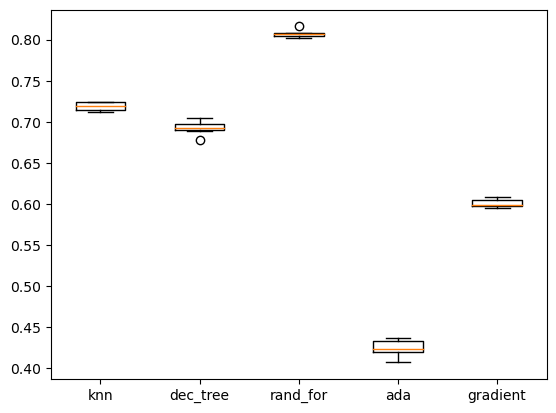

In [85]:
plt.boxplot(results, labels=models.keys())
plt.show()

**Observations:**
\
Looking at this in a pure vacuum, random forest blows the rest of them away. Let's spend our time there digging in and seeing if that result is too good to be true. But maybe I shouldn't be too surprised since this is trees data.

### 3.9.1 Random Forest Classifier

This time I'll use RandomizedSearchCV to tune params. Source: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

#### 3.9.1.0 Create Parameter Grid

In [89]:
#list out our different params
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)] #number of trees in the forest
max_features = ['auto','sqrt'] #number of features to consider at each split
max_depth = [int(x) for x in np.linspace(10, 110, num=11)] #max levels in tree
min_samples_split = [2,5,10] #min samples required to split a node
min_samples_leaf = [1,2,4] #min samples at each leaf node
bootstrap = [True, False] #sampling method using bootsrap or not

#Create random grid
rand_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(rand_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


#### 3.9.1.1 Fit with Random Search

In [ ]:
#Initiate the model
rf = RandomForestClassifier()

#Random Search Cross-Val
rf_rand = RandomizedSearchCV(estimator=rf, param_distributions=rand_grid, n_iter=100, cv=5, verbose=2, random_state=42) #sample 100 param settings, 5 fold cross-val, computation time display

#fit the model
rf_rand.fit(X_res_scaled, y_res)